In [1]:
import os
import shutil
from tqdm.notebook import tqdm

# === Define paths ===
neu_root = '/kaggle/input/neu-surface-defect-database/NEU-DET'
sdnet_root = '/kaggle/input/structural-defects-network-concrete-crack-images'
severstal_root = '/kaggle/input/severstal-steel-defect-detection-tfrecord'

# === Output directory ===
output_dir = '/kaggle/working/FractureScope_dataset'
os.makedirs(output_dir, exist_ok=True)

classes = ['crack', 'corrosion', 'scratch']
for cls in classes:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

# === Helper: Copy all images from folder into class folder ===
def copy_images(src_folder, dst_folder, exts=['.jpg', '.png']):
    count = 0
    if not os.path.exists(src_folder):
        print(f'⚠️ Warning: {src_folder} does not exist — skipping.')
        return 0
    for fname in os.listdir(src_folder):
        if any(fname.lower().endswith(ext) for ext in exts):
            src = os.path.join(src_folder, fname)
            dst = os.path.join(dst_folder, fname)
            shutil.copy2(src, dst)
            count += 1
    return count

### === 1️⃣ Crack === (From SDNET Cracked folders)
print('🔹 Copying CRACK images (from SDNET)...')
crack_count = 0
for subfolder in ['Decks', 'Pavements', 'Walls']:
    crack_folder = os.path.join(sdnet_root, subfolder, 'Cracked')
    crack_count += copy_images(crack_folder, os.path.join(output_dir, 'crack'))
print(f'✅ Copied {crack_count} crack images.')

### === 2️⃣ Corrosion === (From NEU pitted_surface + rolled-in_scale)
print('\n🔹 Copying CORROSION images (from NEU)...')
corrosion_count = 0
for defect in ['pitted_surface', 'rolled-in_scale']:  # fixed lowercase
    neu_folder = os.path.join(neu_root, 'train/images', defect)
    corrosion_count += copy_images(neu_folder, os.path.join(output_dir, 'corrosion'))
print(f'✅ Copied {corrosion_count} corrosion images.')

### === 3️⃣ Scratch === (From NEU scratches + Severstal ClassId=4)
print('\n🔹 Copying SCRATCH images (NEU + Severstal)...')
scratch_count = 0

# --- NEU scratches
neu_scratch_folder = os.path.join(neu_root, 'train/images', 'scratches')  # fixed lowercase
scratch_count += copy_images(neu_scratch_folder, os.path.join(output_dir, 'scratch'))

# --- Severstal ClassId=4 (Scratch)
import pandas as pd
df = pd.read_csv(os.path.join(severstal_root, 'train.csv'))

# Filter ClassId==4 (Scratch)
scratch_df = df[df['ClassId'] == 4]
severstal_img_dir = os.path.join(severstal_root, 'train_images')

for img_name in tqdm(scratch_df['ImageId'].unique(), desc='Copying Severstal scratch images'):
    img_path = os.path.join(severstal_img_dir, img_name)
    if os.path.exists(img_path):
        dst_path = os.path.join(output_dir, 'scratch', img_name)
        shutil.copy2(img_path, dst_path)
        scratch_count += 1

print(f'✅ Copied {scratch_count} scratch images.')

# === Final Summary ===
print('\n📊 Final dataset summary:')
for cls in classes:
    count = len(os.listdir(os.path.join(output_dir, cls)))
    print(f'- {cls}: {count} images')

print(f'\n✅ Dataset ready at: {output_dir}')


🔹 Copying CRACK images (from SDNET)...
✅ Copied 8484 crack images.

🔹 Copying CORROSION images (from NEU)...
✅ Copied 480 corrosion images.

🔹 Copying SCRATCH images (NEU + Severstal)...


Copying Severstal scratch images:   0%|          | 0/801 [00:00<?, ?it/s]

✅ Copied 240 scratch images.

📊 Final dataset summary:
- crack: 8487 images
- corrosion: 483 images
- scratch: 243 images

✅ Dataset ready at: /kaggle/working/FractureScope_dataset


In [2]:
import cv2
from tqdm.notebook import tqdm

def generate_modalities(src_dir, dst_dir):
    os.makedirs(os.path.join(dst_dir, 'original'), exist_ok=True)
    os.makedirs(os.path.join(dst_dir, 'grayscale'), exist_ok=True)
    os.makedirs(os.path.join(dst_dir, 'thermal'), exist_ok=True)
    
    for fname in tqdm(os.listdir(src_dir), desc=f'Generating modalities for {os.path.basename(dst_dir)}'):
        src_path = os.path.join(src_dir, fname)
        img = cv2.imread(src_path)
        if img is None:
            continue

        # Save original
        shutil.copy2(src_path, os.path.join(dst_dir, 'original', fname))

        # Grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(os.path.join(dst_dir, 'grayscale', fname), gray)

        # Simulated thermal (COLORMAP_JET)
        thermal = cv2.applyColorMap(gray, cv2.COLORMAP_JET)
        cv2.imwrite(os.path.join(dst_dir, 'thermal', fname), thermal)

# Apply for each class
for cls in classes:  # ['crack', 'corrosion', 'scratch']
    src_dir = os.path.join(output_dir, cls)
    dst_dir = os.path.join(output_dir, cls)
    generate_modalities(src_dir, dst_dir)

print('✅ All modalities generated.')


Generating modalities for crack:   0%|          | 0/8487 [00:00<?, ?it/s]

Generating modalities for corrosion:   0%|          | 0/483 [00:00<?, ?it/s]

Generating modalities for scratch:   0%|          | 0/243 [00:00<?, ?it/s]

✅ All modalities generated.


In [4]:
from sklearn.model_selection import train_test_split

split_dir = '/kaggle/working/FractureScope_dataset_split'
os.makedirs(split_dir, exist_ok=True)

for split in ['train', 'val']:
    for cls in classes:
        for modality in ['original', 'grayscale', 'thermal']:
            os.makedirs(os.path.join(split_dir, split, cls, modality), exist_ok=True)

for cls in classes:
    orig_dir = os.path.join(output_dir, cls, 'original')
    filenames = os.listdir(orig_dir)
    
    train_files, val_files = train_test_split(filenames, test_size=0.2, random_state=42)
    
    for split, file_list in zip(['train', 'val'], [train_files, val_files]):
        for fname in file_list:
            for modality in ['original', 'grayscale', 'thermal']:
                src = os.path.join(output_dir, cls, modality, fname)
                dst = os.path.join(split_dir, split, cls, modality, fname)
                shutil.copy2(src, dst)

print('✅ Train/Val split with all modalities completed.')


✅ Train/Val split with all modalities completed.


In [60]:
import torch
import torch.nn as nn
import torchvision.models as models

class FractureNet(nn.Module):
    def __init__(self, num_classes=3):
        super(FractureNet, self).__init__()
        
        # Load a pre-trained ResNet18 model
        self.backbone = models.resnet18(weights='IMAGENET1K_V1')
        
        # Modify the first convolutional layer to accept 7 input channels
        self.backbone.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Modify the final fully connected layer to output the desired number of classes (3)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)


In [61]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

class FractureDataset(Dataset):
    def __init__(self, data_dir, classes, modalities, transform=None):
        self.data_dir = data_dir
        self.classes = classes
        self.modalities = modalities
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Collect all image paths and their corresponding labels
        for idx, cls in enumerate(classes):
            cls_dir = os.path.join(data_dir, cls)
            for modality in modalities:
                modality_dir = os.path.join(cls_dir, modality)
                for fname in os.listdir(modality_dir):
                    self.image_paths.append(os.path.join(modality_dir, fname))
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')  # Make sure it's RGB for consistency

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label  # Ensure it's just two values (image and label)




# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and data loaders
train_dir = '/kaggle/working/FractureScope_dataset_split/train'
val_dir = '/kaggle/working/FractureScope_dataset_split/val'

train_dataset = FractureDataset(train_dir, classes, ['original', 'grayscale', 'thermal'], transform=transform)
val_dataset = FractureDataset(val_dir, classes, ['original', 'grayscale', 'thermal'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


Train samples: 27384
Validation samples: 13566


In [62]:
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import accuracy_score

# Set device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, optimizer, and loss function
model = FractureNet(num_classes=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler (optional)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Function for training the model for one epoch
def train_epoch(model, train_loader, optimizer, criterion):
    model.train()  # Set model to training mode
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for imgs, labels in tqdm(train_loader, desc="Training Epoch"):
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(imgs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)  # Accumulate loss
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    epoch_loss = running_loss / len(train_loader.dataset)
    
    return epoch_loss, accuracy

# Function to evaluate the model on the validation set
def evaluate(model, val_loader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Evaluating"):
            imgs, labels = imgs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(imgs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * imgs.size(0)  # Accumulate loss
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    epoch_loss = running_loss / len(val_loader.dataset)
    
    return epoch_loss, accuracy

# Training loop
num_epochs = 10
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc * 100:.2f}%")

 # Evaluate on validation set
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc * 100:.2f}%")
    
    # Save the model if it has the best validation accuracy
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved best model with accuracy {best_val_accuracy * 100:.2f}%")
    
    # Step the scheduler (if using LR scheduler)
    scheduler.step()

print('Training complete.')


Training Epoch:   0%|          | 0/1712 [00:00<?, ?it/s]

Train Loss: 0.1397 | Train Accuracy: 94.87%


Evaluating:   0%|          | 0/848 [00:00<?, ?it/s]

Val Loss: 0.0967 | Val Accuracy: 97.12%
Saved best model with accuracy 97.12%


Training Epoch:   0%|          | 0/1712 [00:00<?, ?it/s]

Train Loss: 0.0549 | Train Accuracy: 98.11%


Evaluating:   0%|          | 0/848 [00:00<?, ?it/s]

Val Loss: 0.0418 | Val Accuracy: 98.74%
Saved best model with accuracy 98.74%


Training Epoch:   0%|          | 0/1712 [00:00<?, ?it/s]

Train Loss: 0.0361 | Train Accuracy: 98.78%


Evaluating:   0%|          | 0/848 [00:00<?, ?it/s]

Val Loss: 0.0226 | Val Accuracy: 99.40%
Saved best model with accuracy 99.40%


Training Epoch:   0%|          | 0/1712 [00:00<?, ?it/s]

Train Loss: 0.0235 | Train Accuracy: 99.21%


Evaluating:   0%|          | 0/848 [00:00<?, ?it/s]

Val Loss: 0.0221 | Val Accuracy: 99.32%


Training Epoch:   0%|          | 0/1712 [00:00<?, ?it/s]

Train Loss: 0.0217 | Train Accuracy: 99.24%


Evaluating:   0%|          | 0/848 [00:00<?, ?it/s]

Val Loss: 0.0362 | Val Accuracy: 98.74%


Training Epoch:   0%|          | 0/1712 [00:00<?, ?it/s]

Train Loss: 0.0147 | Train Accuracy: 99.57%


Evaluating:   0%|          | 0/848 [00:00<?, ?it/s]

Val Loss: 0.0204 | Val Accuracy: 99.43%
Saved best model with accuracy 99.43%


Training Epoch:   0%|          | 0/1712 [00:00<?, ?it/s]

Train Loss: 0.0144 | Train Accuracy: 99.57%


Evaluating:   0%|          | 0/848 [00:00<?, ?it/s]

Val Loss: 0.0153 | Val Accuracy: 99.59%
Saved best model with accuracy 99.59%


Training Epoch:   0%|          | 0/1712 [00:00<?, ?it/s]

Train Loss: 0.0034 | Train Accuracy: 99.88%


Evaluating:   0%|          | 0/848 [00:00<?, ?it/s]

Val Loss: 0.0048 | Val Accuracy: 99.90%
Saved best model with accuracy 99.90%


Training Epoch:   0%|          | 0/1712 [00:00<?, ?it/s]

Train Loss: 0.0019 | Train Accuracy: 99.93%


Evaluating:   0%|          | 0/848 [00:00<?, ?it/s]

Val Loss: 0.0064 | Val Accuracy: 99.90%


Training Epoch:   0%|          | 0/1712 [00:00<?, ?it/s]

Train Loss: 0.0009 | Train Accuracy: 99.97%


Evaluating:   0%|          | 0/848 [00:00<?, ?it/s]

Val Loss: 0.0051 | Val Accuracy: 99.91%
Saved best model with accuracy 99.91%
Training complete.


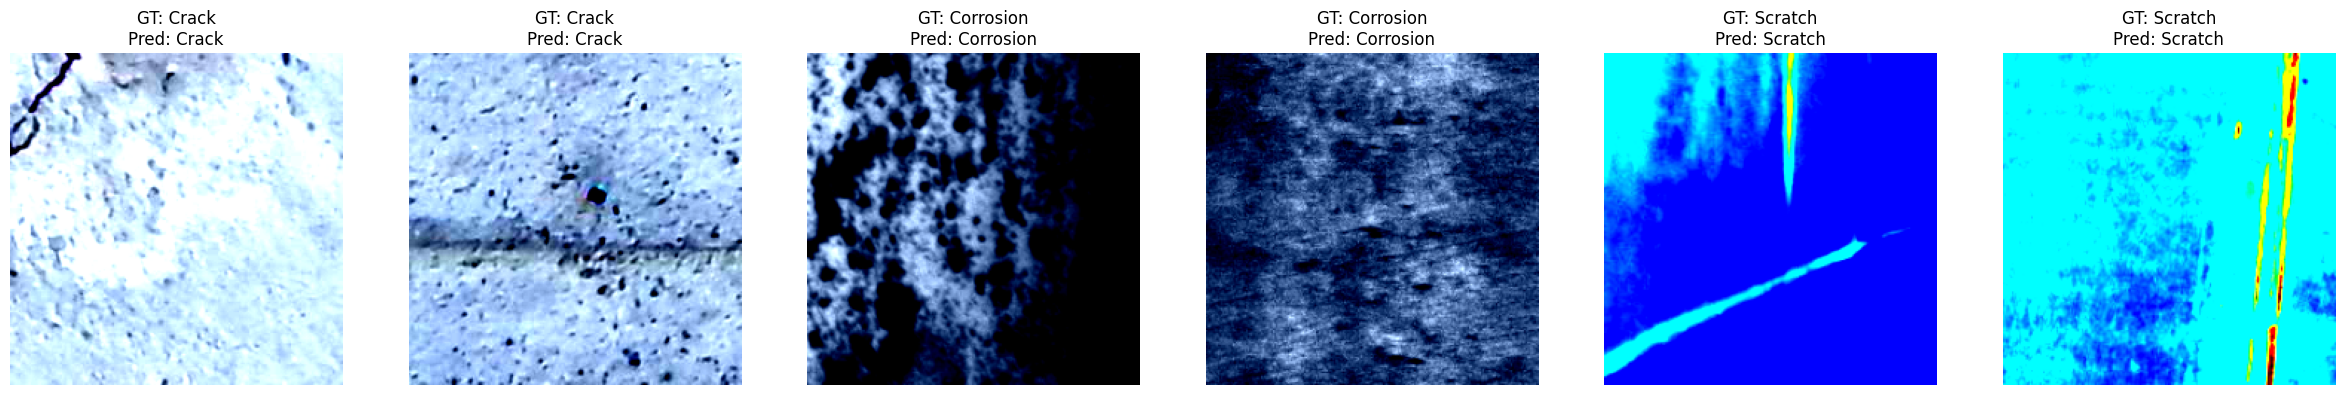

In [79]:
# Sample balanced images from dataset — no retraining needed
def plot_balanced_predictions(model, dataset, class_names, samples_per_class=2):
    model.eval()
    
    # Find indices of each class
    class_indices = {i: [] for i in range(len(class_names))}
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        class_indices[label].append(idx)
    
    # Sample fixed number per class
    sampled_indices = []
    for cls, indices in class_indices.items():
        sampled = random.sample(indices, k=min(samples_per_class, len(indices)))
        sampled_indices.extend(sampled)
    
    # Load sampled images
    images = []
    labels = []
    for idx in sampled_indices:
        image, label = dataset[idx]
        images.append(image)
        labels.append(label)
    
    images = torch.stack(images).to(device)
    labels = torch.tensor(labels).to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Plot
    fig, axes = plt.subplots(1, len(images), figsize=(5 * len(images), 5))
    if len(images) == 1:
        axes = [axes]

    for ax, img, label, pred in zip(axes, images, labels, predicted):
        ax.imshow(img.permute(1, 2, 0).cpu())
        ax.set_title(f"GT: {class_names[label]}\nPred: {class_names[pred]}")
        ax.axis('off')

    plt.show()

# Example usage
plot_balanced_predictions(model, val_loader.dataset, class_names, samples_per_class=2)


In [74]:
from sklearn.metrics import precision_score, recall_score

y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')


Precision: 1.00
Recall: 1.00


In [71]:
y_true = []
y_pred = []

# Set the model to evaluation mode
model.eval()

# No gradient calculation needed for validation
with torch.no_grad():
    for images, labels in val_loader:  # Assuming val_loader is your validation DataLoader
        # Move data to the same device as the model (if necessary)
        images = images.to(device)
        labels = labels.to(device)

        # Make predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels
        y_true.extend(labels.cpu().numpy())  # .cpu() in case you use a GPU
        y_pred.extend(predicted.cpu().numpy())

# Now y_true and y_pred are ready to use


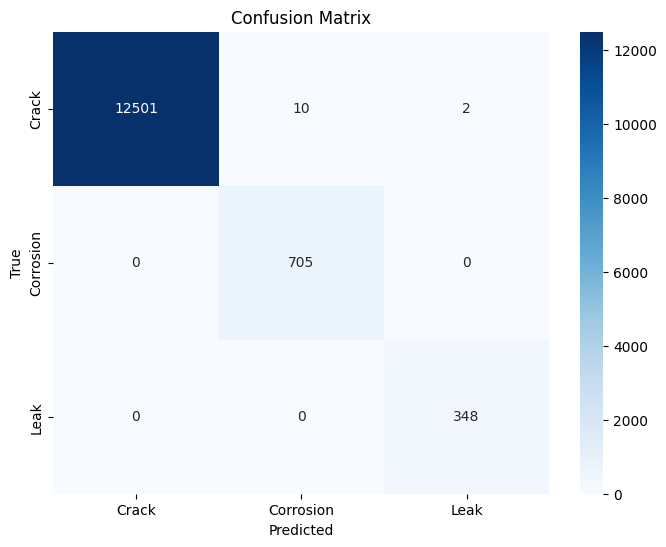

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
